# FSDP2 Fully Sharded

In [1]:
import jupytertracerviz
from jupytertracerviz import init_multigpus_repl, multigpus

init_multigpus_repl()

In [2]:
%%multigpus

import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleDeepNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(SimpleDeepNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        layers = [nn.Linear(embedding_dim, hidden_dim), nn.ReLU()]
        
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())

        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.mean(dim=1)
        x = self.hidden_layers(x)
        logits = self.output_layer(x)
        return logits
        
model_hidden_size = 8192
vocab_size = 200000

In [3]:
%%multigpus

from torch.distributed._composable.fsdp import fully_shard, MixedPrecisionPolicy

model = SimpleDeepNet(vocab_size, model_hidden_size, model_hidden_size, 1)
fully_shard(model.embedding)
fully_shard(model.hidden_layers)
fully_shard(model.output_layer)
fully_shard(model)

model.to(device="cuda").to(torch.bfloat16)

In [4]:
%%multigpus

model.embedding.weight

[GPU 0] DTensor(local_tensor=tensor([[ 2.6250, -0.3477, -0.2061,  ...,  1.0469,  0.4668,  1.2812],
        [-0.0425,  0.5586,  0.6719,  ..., -0.7734, -0.5703,  0.2852],
        [-0.3145, -0.7148,  0.4551,  ...,  0.9844,  0.7695,  0.3301],
        ...,
        [ 0.6562, -0.5039,  1.0781,  ..., -1.6328,  1.2656,  1.0234],
        [ 0.2461,  0.1846,  0.4785,  ..., -0.8789,  0.2178,  0.2988],
        [ 0.4180,  0.6641, -1.0703,  ..., -1.4297, -0.4746, -0.9062]],
       device='cuda:0', dtype=torch.bfloat16), device_mesh=DeviceMesh('cuda', [0, 1, 2]), placements=(Shard(dim=0),))
[GPU 2] DTensor(local_tensor=tensor([[ 0.2793, -0.2383,  1.7266,  ..., -1.2891, -0.3047, -1.2500],
        [-1.6250, -0.2178, -0.7969,  ..., -0.3047, -2.4844, -0.3164],
        [ 1.3359, -0.2480,  1.7031,  ..., -1.4375,  0.1553,  0.4141],
        ...,
        [-0.7305, -1.2500,  0.4238,  ..., -0.2314,  0.6797, -1.1172],
        [ 0.5312,  0.7188,  0.2969,  ..., -0.0889,  1.2812, -1.0625],
        [ 0.5391,  0.1436, 

In [5]:
%%multigpus

model.embedding.weight._local_tensor.shape

[GPU 1] torch.Size([66667, 8192])
[GPU 0] torch.Size([66667, 8192])
[GPU 2] torch.Size([66666, 8192])


In [6]:
%%multigpus

model.output_layer.weight._local_tensor.shape

[GPU 0] torch.Size([66667, 8192])
[GPU 1] torch.Size([66667, 8192])
[GPU 2] torch.Size([66666, 8192])


In [13]:
%%multigpus

model.output_layer.weight

[GPU 0] DTensor(local_tensor=tensor([[-5.1880e-03,  8.7280e-03,  6.9885e-03,  ...,  6.1951e-03,
         -2.0447e-03, -5.7220e-04],
        [ 4.3945e-03,  6.8970e-03, -8.2397e-03,  ...,  5.5237e-03,
          9.8877e-03,  8.5449e-03],
        [ 7.7515e-03,  3.1586e-03, -9.3384e-03,  ..., -6.2943e-04,
          6.2256e-03, -1.1978e-03],
        ...,
        [ 8.0566e-03, -5.9204e-03, -1.3123e-03,  ..., -6.2561e-04,
         -1.0437e-02, -2.5024e-03],
        [-1.1047e-02,  3.4180e-03,  5.9605e-05,  ..., -5.6458e-03,
          3.3112e-03, -9.4604e-03],
        [-6.4697e-03,  8.7891e-03,  2.1515e-03,  ..., -6.8970e-03,
          1.9302e-03,  1.6937e-03]], device='cuda:0', dtype=torch.bfloat16), device_mesh=DeviceMesh('cuda', [0, 1, 2]), placements=(Shard(dim=0),))
[GPU 2] DTensor(local_tensor=tensor([[ 0.0040,  0.0008, -0.0045,  ..., -0.0018, -0.0010,  0.0098],
        [ 0.0008, -0.0013,  0.0104,  ..., -0.0074, -0.0082,  0.0037],
        [-0.0070, -0.0049, -0.0079,  ..., -0.0084,  0.0012,

In [14]:
%%multigpus

import os

local_rank = os.environ.get('LOCAL_RANK')

x = torch.randn(8192, 8192, dtype = torch.bfloat16).cuda()
with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA,
    ],
    record_shapes = True, profile_memory = True,
) as prof:
    y_ = model.output_layer(x)
prof.export_chrome_trace(f'fsdp2_forward_{local_rank}.json')

Dumping trace data, total entries: 5549


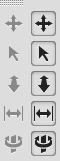
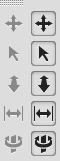
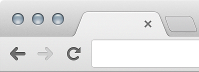
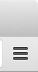
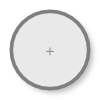
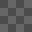
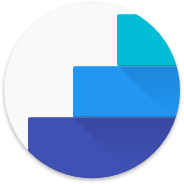
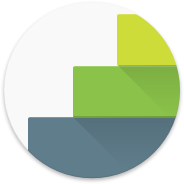
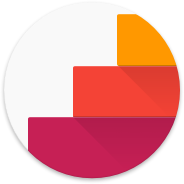
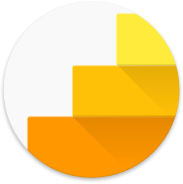

In [15]:
from glob import glob

jupytertracerviz.visualize(glob('fsdp2_forward_*.json'), height = "800")